In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from scipy.signal import butter, filtfilt
from scipy.io import loadmat
from os.path import exists

# Initialization

In [2]:
## Fixed Initialization:
train_percentage=0.7 
participants = 89
excluded_numbers = [8, 35, 39, 81]
label_file_path='./details/labels.csv'
subjects = [idx for idx in range(1, participants+1) if idx not in excluded_numbers]
subjects_train = subjects[:int(len(subjects)*train_percentage)]
subjects_test = subjects[int(len(subjects)*train_percentage):]
window_time = 2
label_name='Happy( active+vigorous+ful_of_energy)'
label_range=2
print(len(subjects_train),len(subjects_test))

59 26


In [3]:
num_label0 = 0
num_label1 = 0
for i in subjects_train:
    df = pd.read_csv(label_file_path)
    tension_value = df.loc[df['ID'] == i, label_name].values[0]
    if tension_value<=label_range:
        label = 1
        num_label0 += 1
    else:
        label = 0
        num_label1 += 1

print(num_label0, num_label1)

4 55


In [4]:
## Variable Initialization
zero_label_augmentation_train=13
one_label_augmentation_train=1


zero_label_augmentation=3
one_label_augmentation=1
with open('./details/feature.csv', 'w') as f:
    pass


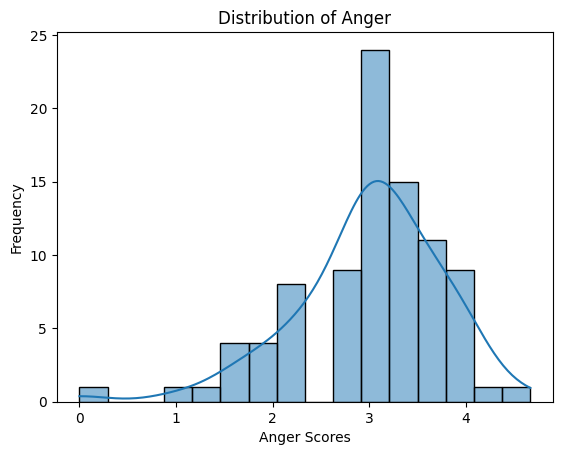

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv(label_file_path)
# Assuming df['Anger (2, 9, 16, 22, 29, 36, and 37)'] is a pandas Series containing your data.
sns.histplot(data=df, x=label_name, kde=True)
plt.title('Distribution of Anger')
plt.xlabel('Anger Scores')
plt.ylabel('Frequency')
plt.show()


# Main Functions


In [7]:
def load_data(subject):
    if exists('./eeg_data/{}.mat'.format(subject)):
        file = './eeg_data/{}.mat'.format(subject)
        mat_data = loadmat(file)
        eeg_data = (mat_data['EEG']['data'][0, 0])*1e-6
        channel_names = [ch[0] for ch in mat_data['EEG']['chanlocs'][0, 0]['labels'][0]]
        sampling_freq = mat_data['EEG']['srate'][0, 0][0, 0]
        return eeg_data, channel_names, sampling_freq

In [8]:
def initialize_label(i,label_file_path,label_range=3,label_name=label_name):
    df = pd.read_csv(label_file_path)
    tension_value = df.loc[df['ID'] == i, label_name].values[0]
    if tension_value<=label_range:
        label = 1
        return label
    else:
        label = 0
        return label


In [9]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [10]:
def filtering_and_concatenating(eeg_data,channel_names,lowcut=0.5,highcut=45.0,fs=250):
    eeg_data_fp1 = eeg_data[channel_names.index('FP1'), : ]
    eeg_data_fp2 = eeg_data[channel_names.index('FP2'), : ]
    eeg_data_fp1 = eeg_data_fp1.reshape(1, -1)
    eeg_data_fp2 = eeg_data_fp2.reshape(1, -1)
    filtered_fp1 = bandpass_filter(eeg_data_fp1, lowcut, highcut, fs)
    filtered_fp2 = bandpass_filter(eeg_data_fp2, lowcut, highcut, fs)
    eeg_data = np.concatenate((filtered_fp1, filtered_fp2), axis=0)
    return eeg_data

In [11]:
def remove_baseline_drift(eeg_signal, poly_order=6):
    time=np.arange(len(eeg_signal))
    coeffs = np.polyfit(time, eeg_signal, poly_order)
    baseline = np.polyval(coeffs, time)
    corrected_eeg_signal = eeg_signal - baseline
    return corrected_eeg_signal

In [12]:
def fft_features(select_data, label,zero_label_augmentation=1,one_label_augmentation=1,window_time=2,training=True):

    if training==True:
        file='./details/train_feature.csv'
    else:
        file='./details/test_feature.csv'
    if label == 0:
        augment = zero_label_augmentation
    elif label == 1:
        augment = one_label_augmentation
    segment_length = window_time * 250 
    step = segment_length // augment 
    segments = []
    for start_idx in np.arange(0, select_data.shape[1] - segment_length + 1, step):

        segment = select_data[:, start_idx:start_idx + segment_length]
        segments.append(segment)
    for seg in segments:
        seg_fft = []
        for i in range(seg.shape[0]):
            seg[i, :] = remove_baseline_drift(seg[i, :])
            fft = np.abs(np.fft.fft(seg[i, :]))[0:70]
            fft = fft / np.sum(fft)
            with open(file, 'a') as f:
                for i in range(len(fft)):
                    f.write(str(fft[i]) + ',')
            seg_fft.append(fft)
        with open(file, 'a') as f:
            f.write(str(label) + '\n')
        
    return None

In [13]:
def preprocessing(subjects,label_file_path,label_range=3,zero_label_augmentation=1,one_label_augmentation=1,window_time=2,training=True):
    for i in subjects:
        label=initialize_label(i,label_file_path,label_range)
        eeg_data, channel_names, _ = load_data(i)
        eeg_data=filtering_and_concatenating(eeg_data, channel_names)
        fft_features(eeg_data, label,zero_label_augmentation=zero_label_augmentation,one_label_augmentation=one_label_augmentation,window_time=window_time,training=training)
    return None

# Training and Testing Data

In [ ]:
preprocessing(subjects_train,label_file_path,label_range=label_range,zero_label_augmentation=zero_label_augmentation_train,one_label_augmentation=one_label_augmentation_train,window_time=window_time,training=True)
preprocessing(subjects_test,label_file_path,label_range=label_range,zero_label_augmentation=zero_label_augmentation,one_label_augmentation=one_label_augmentation,window_time=window_time,training=False)

In [ ]:
df=pd.read_csv('./details/train_feature.csv')

In [ ]:
df['1'].value_counts()

1
1    125855
0    112726
Name: count, dtype: int64

In [ ]:
df1=pd.read_csv('./details/test_feature.csv')

In [ ]:
df1['1'].value_counts()

1
1    48748
0    37139
Name: count, dtype: int64